# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

**2019 update:** Changes have been made to the display of environments due to the previous `viewer` being incompatible with newer versions of Gym.

**2022 update:** Rendering was disabled, and the notebook now uses the `colabgymrender` package to render a video.

**2023 update:** Changed to packages `gymnasium` and `renderlab`, and to `CartPole-v1`.

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gymnasium.farama.org/environments/classic_control/cart_pole/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [ ]:
!pip install gymnasium
!pip install renderlab

 **If run on your local machine**, you may need to install `gymnasium[classic-control]` by running the following line:

In [ ]:
!pip install "gymnasium[classic-control]"

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import renderlab as rl

First we create the environment:

In [2]:
env = gym.make('CartPole-v1') # Create environment

A state in this environment is four numbers describing the position and speed of the cart along with the angle and angular speed of the pole.

There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [3]:
s, _ = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [-0.04321066  0.03780806 -0.02221748 -0.02023987]
sample action: 0


Let us see how the environment looks when we just take random actions. Note that the episode ends when the pole either 1) is more than 15 degrees from vertical, 2) more outside of the frame or 3) the pole is successfully balanced for some fixed duration.

In [4]:
env = gym.make("CartPole-v1", render_mode = "rgb_array") # Create environment
env = rl.RenderFrame(env, "./output") # To display environment in the notebook
env.reset() # Reset environment

# Run environment
while True:
    action = env.action_space.sample() # Get a random action
    _, _, done, _, _ = env.step(action) # Take a step
    if done: break # Break if environment is done

env.close() # Close environment
env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [5]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden_1 = nn.Linear(n_inputs, n_hidden)
        #self.hidden_2 = nn.Linear(n_hidden, n_hidden*2)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        # x = self.hidden_2(x)
        # x = F.leaky_relu(x, negative_slope=0.01)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [6]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [7]:
n_inputs = env.observation_space.shape[0]
n_hidden = 128
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [ ]:
# training settings
num_episodes = 1200
rollout_limit = 500 # max rollout length
discount_factor = 1 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 5e-4 # you know this by now
val_freq = 100 # validation frequency

# setup policy network
policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)

# train policy network
try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s, _ = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                a = torch.multinomial(a_prob, num_samples=1).squeeze().numpy()
            s1, r, done, _, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        states, actions, rewards, = zip(*rollout)
        states = np.vstack(states)
        actions = np.vstack(actions)
        rewards = np.array(rewards, dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s, _ = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
                        a = a_prob.argmax().item()
                    s, r, done, _, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

start training
 100. mean training reward:  24.63, mean validation reward:  25.60, mean loss:  8.7090
 200. mean training reward:  29.04, mean validation reward:  93.80, mean loss: 10.1292
 300. mean training reward:  36.68, mean validation reward:  71.90, mean loss: 12.4341
 400. mean training reward:  51.84, mean validation reward:  74.30, mean loss: 16.8793
 500. mean training reward:  70.39, mean validation reward: 424.90, mean loss: 22.4656
 600. mean training reward: 109.18, mean validation reward: 491.30, mean loss: 34.0129
 700. mean training reward: 139.99, mean validation reward: 484.60, mean loss: 42.9980
 800. mean training reward: 170.62, mean validation reward: 458.30, mean loss: 51.3449
 900. mean training reward: 247.03, mean validation reward: 500.00, mean loss: 73.4134
1000. mean training reward: 262.64, mean validation reward: 500.00, mean loss: 76.7601
1100. mean training reward: 329.31, mean validation reward: 500.00, mean loss: 94.2814
1200. mean training reward: 

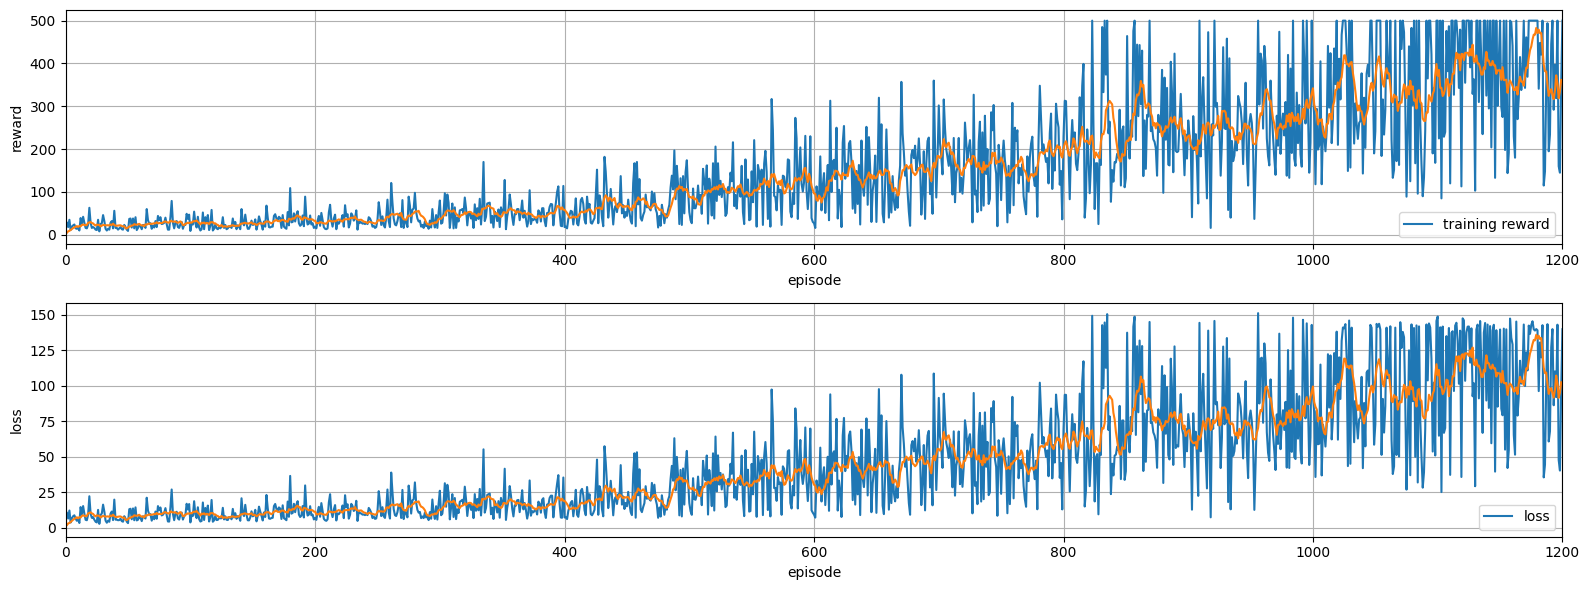

In [9]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

In [10]:
env = rl.RenderFrame(env, "./gym-results") # Create wrapper to display environment
s,_ = env.reset()

for _ in range(500):
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _, _ = env.step(a)
    if done: break

env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return at timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

> So I went thorugh different kinds of iterations and implementations. Having a lower learning rate and some more episodes worked very well for me. However, there is some variability here for how quickly the model sometimes completely solves the problem, explaining why some iterations may look like they could have stopped earlier. Next there was a need for more hidden neurons, and while adding more layers definitely improved the performance, just having a single layer with a bit more neurons, improved the performance just as well while keeping the training time a bit lower as well. Lastly, tuning the discount factor heavily imparcted the model alot and in a negative way, and adding more layers or neurons didn't solve this problem for me. Therefore, I kept the value at 1 for the final model. The final model can consistently hold the lever up right for the entirety of the rollout duration.

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

The results below are caluclated using python. The full code cell can be found after the markdown cell.
* > Is the total reward on the sequence: $R_{tot} = 0+1+1+1+0+1+1+0+0+0 = 5$
* > Is the reward we can expect in the future from that timestep: $R_t = [5, 5, 4, 3, 2, 2, 1, 0, 0, 0]$
* > Is the discounted reward we can expect in the future from that timestep: <br> $R_{t,discounted} = [3.561, 3.957, 3.285, 2.539, 1.71, 1.9, 1.0, 0.0, 0.0, 0.0]$

### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

> The reason for the behaviour becomes pretty obvious, if we think about how we are choosing our actions when training and validating the model. When training we are choosing an action based on softmax sampling to sometimes achieve an exploration type behaviour, which won't always lead to a good reward. However, during validation we always act greedy choosing the action with the highest probability of yielding good rewards in the future. So while the actions aren't very good at the start, as the model gets better during the training process, the validation reward will get better than the training reward.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

> By using softmax action selection we get a probability for each action, which is depedent on the amount of reward it can yield in the future. We then sample an action from this multinomial distribution, where an action with a higher probability of course has a larger probability of getting chosen. So in the start where all actions are treated equally, we will explore a lot, and as the agent learns the environment, we will slowly begin to transition into exploitation by being more and more likely to choose an action that has a higher probability.

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate. 

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*

In [5]:
# Reward calculations for exercise 2
r = [0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

# Total reward
print(sum(r))

# Future reward
print([sum(r[t:]) for t in range(len(r))])

# Discounted reward
print([round(sum((0.9**k)*r[t + k] for k in range(len(r[t:]))), 3) for t in range(len(r))])

5
[5, 5, 4, 3, 2, 2, 1, 0, 0, 0]
[3.561, 3.957, 3.285, 2.539, 1.71, 1.9, 1.0, 0.0, 0.0, 0.0]


### Book Exercise

> Exercise 11 from chapter 3: What would go wrong if we used $\mu>1$ or $\mu<0$ in the momentum technique?

- If $\mu$ is greater than 1 we tell the model to over prioritize the previous gradients. This results in large update steps, which can make the model much more likely to overshooting, so missing the minima, and thus not converge and instead oscillate.
- If $\mu$ is less than 0, so negative, we reverse the direction of our steps. So instead of going down into the vally, we instead climb the mountain, again making it extremely hard, if not impossible, for the model to converge towards the minima.